Overview
In this example, you will train an autoencoder to detect anomalies on the ECG5000 dataset. This dataset contains 5,000 Electrocardiograms, each with 140 data points. You will use a simplified version of the dataset, where each example has been labeled either 0 (corresponding to an abnormal rhythm), or 1 (corresponding to a normal rhythm). You are interested in identifying the abnormal rhythms

This is a labeled dataset, so you could phrase this as a supervised learning problem. The goal of this example is to illustrate anomaly detection concepts you can apply to larger datasets, where you do not have labels available (for example, if you had many thousands of normal rhythms, and only a small number of abnormal rhythms).
How will you detect anomalies using an autoencoder? Recall that an autoencoder is trained to minimize reconstruction error. You will train an autoencoder on the normal rhythms only, then use it to reconstruct all the data. Our hypothesis is that the abnormal rhythms will have higher reconstruction error. You will then classify a rhythm as an anomaly if the reconstruction error surpasses a fixed threshold.

Load ECG data
The dataset you will use is based on one from timeseriesclassification.com.

In [1]:
import pandas as pd

In [2]:
# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [3]:
raw_data

array([[-0.11252183, -2.8272038 , -3.7738969 , ...,  0.92528624,
         0.19313742,  1.        ],
       [-1.1008778 , -3.9968398 , -4.2858426 , ...,  1.1196209 ,
        -1.4362499 ,  1.        ],
       [-0.56708802, -2.5934502 , -3.8742297 , ...,  0.90422673,
        -0.42179659,  1.        ],
       ...,
       [-1.1229693 , -2.2529248 , -2.8676281 , ..., -2.0083694 ,
        -1.8083338 ,  0.        ],
       [-0.54770461, -1.8895451 , -2.8397786 , ...,  1.1504486 ,
         0.80493225,  0.        ],
       [-1.3517791 , -2.2090058 , -2.5202247 , ..., -1.577823  ,
        -0.68453092,  0.        ]])

In [5]:
from sklearn.model_selection import train_test_split

In [ ]:
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

In [7]:
labels

array([1., 1., 1., ..., 0., 0., 0.])

In [8]:
data

array([[-0.11252183, -2.8272038 , -3.7738969 , ...,  0.12343082,
         0.92528624,  0.19313742],
       [-1.1008778 , -3.9968398 , -4.2858426 , ...,  0.77381971,
         1.1196209 , -1.4362499 ],
       [-0.56708802, -2.5934502 , -3.8742297 , ...,  0.32109663,
         0.90422673, -0.42179659],
       ...,
       [-1.1229693 , -2.2529248 , -2.8676281 , ..., -2.874136  ,
        -2.0083694 , -1.8083338 ],
       [-0.54770461, -1.8895451 , -2.8397786 , ...,  1.261335  ,
         1.1504486 ,  0.80493225],
       [-1.3517791 , -2.2090058 , -2.5202247 , ..., -2.2600228 ,
        -1.577823  , -0.68453092]])

Normalize the data to [0,1].

In [10]:
import tensorflow as tf

min max scaler

In [16]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data_sc = (train_data - min_val) / (max_val - min_val)
test_data_sc = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data_sc, tf.float32)
test_data = tf.cast(test_data_sc, tf.float32)

In [12]:
min_val

<tf.Tensor: shape=(), dtype=float64, numpy=-6.2808752>

In [13]:
max_val

<tf.Tensor: shape=(), dtype=float64, numpy=7.4021031>

In [18]:
train_data_sc

<tf.Tensor: shape=(3998, 140), dtype=float32, numpy=
array([[0.57030463, 0.46561658, 0.29058117, ..., 0.48504233, 0.4233502 ,
        0.47598344],
       [0.48320588, 0.28246963, 0.16471253, ..., 0.567567  , 0.4677294 ,
        0.2692329 ],
       [0.48144642, 0.35151404, 0.25972766, ..., 0.5479421 , 0.5077544 ,
        0.54298663],
       ...,
       [0.41039047, 0.24164985, 0.13120876, ..., 0.5277313 , 0.5654091 ,
        0.5023885 ],
       [0.5397748 , 0.4140786 , 0.28101394, ..., 0.51266515, 0.43706053,
        0.4426865 ],
       [0.29639772, 0.15988176, 0.18883787, ..., 0.53766966, 0.545786  ,
        0.40826708]], dtype=float32)>

In [19]:
train_data

<tf.Tensor: shape=(3998, 140), dtype=float32, numpy=
array([[0.57030463, 0.46561658, 0.29058117, ..., 0.48504233, 0.4233502 ,
        0.47598344],
       [0.48320588, 0.28246963, 0.16471253, ..., 0.567567  , 0.4677294 ,
        0.2692329 ],
       [0.48144642, 0.35151404, 0.25972766, ..., 0.5479421 , 0.5077544 ,
        0.54298663],
       ...,
       [0.41039047, 0.24164985, 0.13120876, ..., 0.5277313 , 0.5654091 ,
        0.5023885 ],
       [0.5397748 , 0.4140786 , 0.28101394, ..., 0.51266515, 0.43706053,
        0.4426865 ],
       [0.29639772, 0.15988176, 0.18883787, ..., 0.53766966, 0.545786  ,
        0.40826708]], dtype=float32)>

You will train the autoencoder using only the normal rhythms, which are labeled in this dataset as 1. Separate the normal rhythms from the abnormal rhythms.

In [20]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

In [21]:
train_labels

array([ True,  True,  True, ...,  True,  True,  True])

In [ ]:
normal_train_data = train_data[train_labels] # filter train data where train labels is true
normal_test_data = test_data[test_labels]

In [23]:
normal_train_data

<tf.Tensor: shape=(2359, 140), dtype=float32, numpy=
array([[0.57030463, 0.46561658, 0.29058117, ..., 0.48504233, 0.4233502 ,
        0.47598344],
       [0.48320588, 0.28246963, 0.16471253, ..., 0.567567  , 0.4677294 ,
        0.2692329 ],
       [0.48144642, 0.35151404, 0.25972766, ..., 0.5479421 , 0.5077544 ,
        0.54298663],
       ...,
       [0.41039047, 0.24164985, 0.13120876, ..., 0.5277313 , 0.5654091 ,
        0.5023885 ],
       [0.5397748 , 0.4140786 , 0.28101394, ..., 0.51266515, 0.43706053,
        0.4426865 ],
       [0.29639772, 0.15988176, 0.18883787, ..., 0.53766966, 0.545786  ,
        0.40826708]], dtype=float32)>

In [ ]:
anomalous_train_data = train_data[~train_labels] # # filter train data where train labels is false
anomalous_test_data = test_data[~test_labels]

In [25]:
anomalous_train_data

<tf.Tensor: shape=(1639, 140), dtype=float32, numpy=
array([[0.4304001 , 0.35345322, 0.30342638, ..., 0.30506894, 0.262255  ,
        0.2502011 ],
       [0.4494794 , 0.37906834, 0.3202905 , ..., 0.31546655, 0.39611116,
        0.46317974],
       [0.49198422, 0.4355403 , 0.3698029 , ..., 0.5260356 , 0.52524984,
        0.5278486 ],
       ...,
       [0.43457043, 0.362154  , 0.34958026, ..., 0.3179064 , 0.3426891 ,
        0.49215436],
       [0.4814947 , 0.4255184 , 0.38368973, ..., 0.29031053, 0.3311408 ,
        0.4467481 ],
       [0.4276824 , 0.3507402 , 0.31587753, ..., 0.3177887 , 0.33242297,
        0.419218  ]], dtype=float32)>

In [26]:
anomalous_test_data

<tf.Tensor: shape=(440, 140), dtype=float32, numpy=
array([[0.3687897 , 0.30728117, 0.26587984, ..., 0.58551234, 0.5662988 ,
        0.5726404 ],
       [0.45878157, 0.43861866, 0.44218123, ..., 0.29617104, 0.32473418,
        0.43136704],
       [0.344323  , 0.31411245, 0.32462206, ..., 0.3313962 , 0.3809925 ,
        0.45533565],
       ...,
       [0.3493378 , 0.28614876, 0.29047537, ..., 0.31901175, 0.34637472,
        0.45208865],
       [0.5713978 , 0.5637761 , 0.5245046 , ..., 0.12886006, 0.18022895,
        0.26692218],
       [0.4697181 , 0.4619233 , 0.461555  , ..., 0.5800685 , 0.5970339 ,
        0.60342324]], dtype=float32)>

Plot a normal ECG.

In [28]:
import matplotlib.pyplot as plt
import numpy as np

In [30]:
normal_train_data

<tf.Tensor: shape=(2359, 140), dtype=float32, numpy=
array([[0.57030463, 0.46561658, 0.29058117, ..., 0.48504233, 0.4233502 ,
        0.47598344],
       [0.48320588, 0.28246963, 0.16471253, ..., 0.567567  , 0.4677294 ,
        0.2692329 ],
       [0.48144642, 0.35151404, 0.25972766, ..., 0.5479421 , 0.5077544 ,
        0.54298663],
       ...,
       [0.41039047, 0.24164985, 0.13120876, ..., 0.5277313 , 0.5654091 ,
        0.5023885 ],
       [0.5397748 , 0.4140786 , 0.28101394, ..., 0.51266515, 0.43706053,
        0.4426865 ],
       [0.29639772, 0.15988176, 0.18883787, ..., 0.53766966, 0.545786  ,
        0.40826708]], dtype=float32)>

In [ ]:
normal_train_data[0]  # 2d array to numpy array

<tf.Tensor: shape=(140,), dtype=float32, numpy=
array([0.57030463, 0.46561658, 0.29058117, 0.17791584, 0.09538919,
       0.08467858, 0.20195104, 0.3163002 , 0.33732033, 0.41424882,
       0.47070596, 0.4691905 , 0.47767755, 0.4800409 , 0.47027245,
       0.4729927 , 0.47917148, 0.48027468, 0.4692887 , 0.46106863,
       0.46148038, 0.4465829 , 0.45325327, 0.45610094, 0.4489618 ,
       0.4432532 , 0.43402174, 0.44307235, 0.43250525, 0.43014902,
       0.41454658, 0.4120653 , 0.4042028 , 0.41054544, 0.4082913 ,
       0.40342993, 0.39648476, 0.39332044, 0.39158815, 0.39603877,
       0.40746954, 0.4053118 , 0.4173488 , 0.41624558, 0.42334118,
       0.44590637, 0.4455184 , 0.44474098, 0.44404328, 0.45673218,
       0.45217463, 0.4532504 , 0.46082932, 0.46695936, 0.46631944,
       0.4743283 , 0.4629709 , 0.4738895 , 0.46788898, 0.4673448 ,
       0.48026675, 0.4843984 , 0.48574668, 0.48985568, 0.49317348,
       0.4883041 , 0.49913937, 0.5057092 , 0.5078241 , 0.51323026,
       0.52119

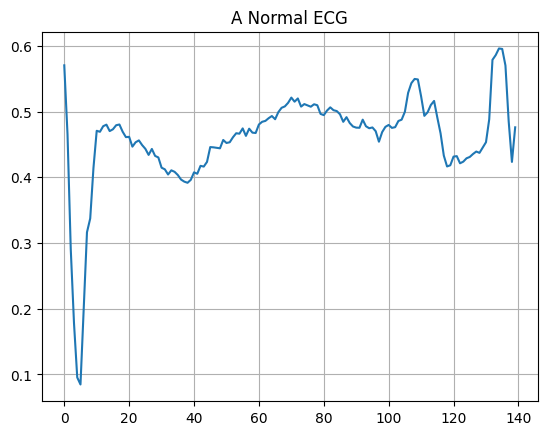

In [31]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

Plot an anomalous ECG

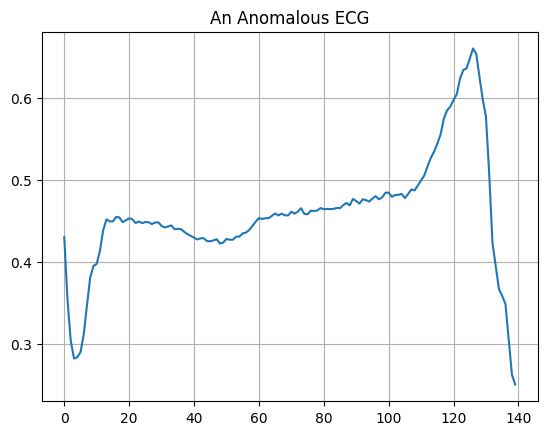

In [32]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

Build the model

In [35]:
from tensorflow.keras import layers ,Model


In [36]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(140, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [37]:
autoencoder.compile(optimizer='adam', loss='mae')

Notice that the autoencoder is trained using only the normal ECGs, but is evaluated using the full test set.

In [38]:
history = autoencoder.fit(normal_train_data, normal_train_data,
          epochs=10,
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - loss: 0.0581 - val_loss: 0.0534
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0562 - val_loss: 0.0519
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0536 - val_loss: 0.0503
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0505 - val_loss: 0.0485
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0468 - val_loss: 0.0469
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0431 - val_loss: 0.0443
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0393 - val_loss: 0.0423
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0360 - val_loss: 0.0411
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0333 - val_loss: 0.0400
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0310 - val_loss: 0.0391


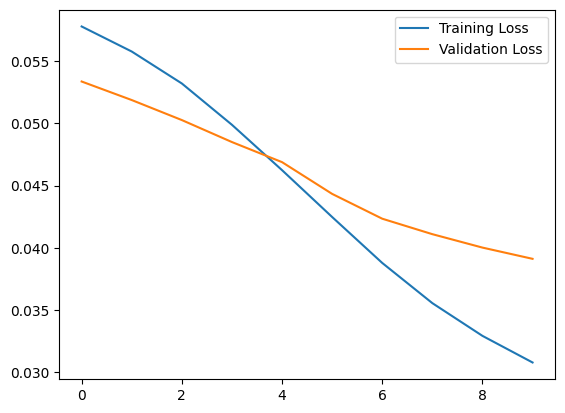

In [39]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

You will soon classify an ECG as anomalous if the reconstruction error is greater than one standard deviation from the normal training examples. First, let's plot a normal ECG from the training set, the reconstruction after it's encoded and decoded by the autoencoder, and the reconstruction error.

In [40]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

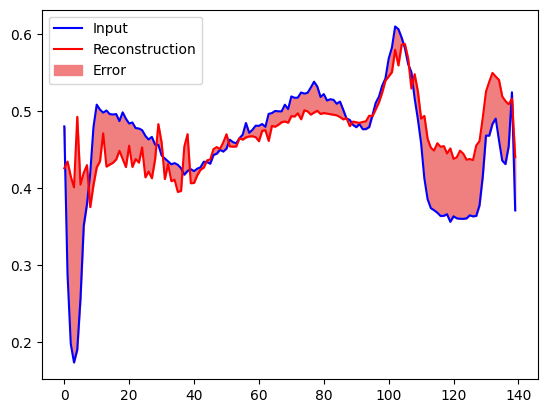

In [42]:
plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

Create a similar plot, this time for an anomalous test example.

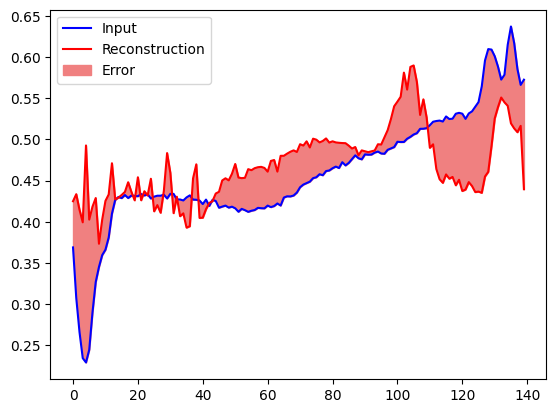

In [43]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

Detect anomalies
Detect anomalies by calculating whether the reconstruction loss is greater than a fixed threshold. In this tutorial, you will calculate the mean average error for normal examples from the training set, then classify future examples as anomalous if the reconstruction error is higher than one standard deviation from the training set.

Plot the reconstruction error on normal ECGs from the training set

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


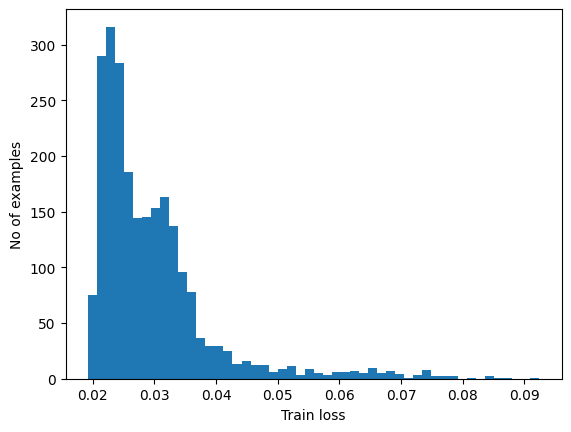

In [ ]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [45]:
reconstructions

array([[0.42790893, 0.43806624, 0.41756222, ..., 0.5106546 , 0.5175934 ,
        0.4422657 ],
       [0.42615232, 0.4356252 , 0.4156965 , ..., 0.5097892 , 0.51719517,
        0.44092372],
       [0.4249413 , 0.4327414 , 0.41458827, ..., 0.5080465 , 0.5157937 ,
        0.4391612 ],
       ...,
       [0.42453104, 0.4318831 , 0.41420186, ..., 0.50755966, 0.51545846,
        0.43866298],
       [0.4266477 , 0.43519887, 0.41616046, ..., 0.50888973, 0.5159663 ,
        0.4408542 ],
       [0.4242414 , 0.43122038, 0.41398215, ..., 0.5071966 , 0.5152627 ,
        0.4381518 ]], dtype=float32)

In [ ]:
train_loss

<tf.Tensor: shape=(2359,), dtype=float32, numpy=
array([0.03408695, 0.0231779 , 0.02966416, ..., 0.02191112, 0.03183687,
       0.0255033 ], dtype=float32)>

In [48]:
train_loss[None,:]

<tf.Tensor: shape=(1, 2359), dtype=float32, numpy=
array([[0.03408695, 0.0231779 , 0.02966416, ..., 0.02191112, 0.03183687,
        0.0255033 ]], dtype=float32)>

In [47]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.039458923


 There are other strategies you could use to select a threshold value above which test examples should be classified as anomalous, the correct approach will depend on your dataset. You can learn more with the links at the end of this tutorial.
If you examine the reconstruction error for the anomalous examples in the test set, you'll notice most have greater reconstruction error than the threshold. By varing the threshold, you can adjust the precision and recall of your classifier.

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


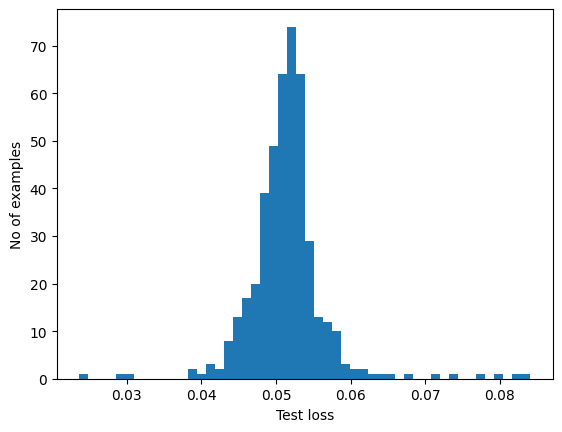

In [49]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

Classify an ECG as an anomaly if the reconstruction error is greater than the threshold

In [50]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [51]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [52]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.944
Precision = 0.9902723735408561
Recall = 0.9089285714285714
